# Economic Indicators

Let's investigate how some economic indicators are related to crime activity in a region.

## Environment Setup

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set(style='whitegrid', rc={'axes.grid' : False})

In [3]:
# load crime data
crimes_df = pd.read_pickle('data/processed_data.pkl')

## **2011**

In [4]:
eco_2011 = pd.read_csv('data/external/Economic_Indicators_2011.csv', index_col='Community Area')
eco_2011.head()

,Community Area Name,Below Poverty Level,Per Capita Income,Unemployment
Community Area,,,,
1,Rogers Park,22.7,23714,7.5
2,West Ridge,15.1,21375,7.9
3,Uptown,22.7,32355,7.7
4,Lincoln Square,9.5,35503,6.8
5,North Center,7.1,51615,4.5


## House Prices

Let's add House Price data to our investigation.

In [5]:
house_prices = pd.read_csv('data/external/avg_house_prices_per_community.csv', index_col='Month', parse_dates=True)
house_prices_2011 = house_prices['2011']

In [6]:
house_prices_2011.groupby('Community Area').mean()

,Avg Price
Community Area,
1.0,128225.000000
2.0,173050.000000
3.0,206100.000000
4.0,302383.333333
5.0,364525.000000
6.0,298575.000000
7.0,407564.583333
8.0,256814.285714
9.0,265991.666667


In [7]:
eco_2011 = eco_2011.join(house_prices_2011.groupby('Community Area').mean(),
                         on='Community Area')
eco_2011.rename(columns={'Avg Price': 'House Avg Price'}, inplace=True)

In [8]:
crimes_2007_2011 = crimes_df['2007':'2011']

In [9]:
crimes_2007_2011.columns

Index(['ID', 'Case Number', 'Block', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'Beat', 'District',
       'Ward', 'Community Area', 'FBI Code', 'Year', 'Updated On', 'Latitude',
       'Longitude'],
      dtype='object')

In [10]:
eco_indicators = ['Below Poverty Level', 'Per Capita Income', 'Unemployment', 'House Avg Price']

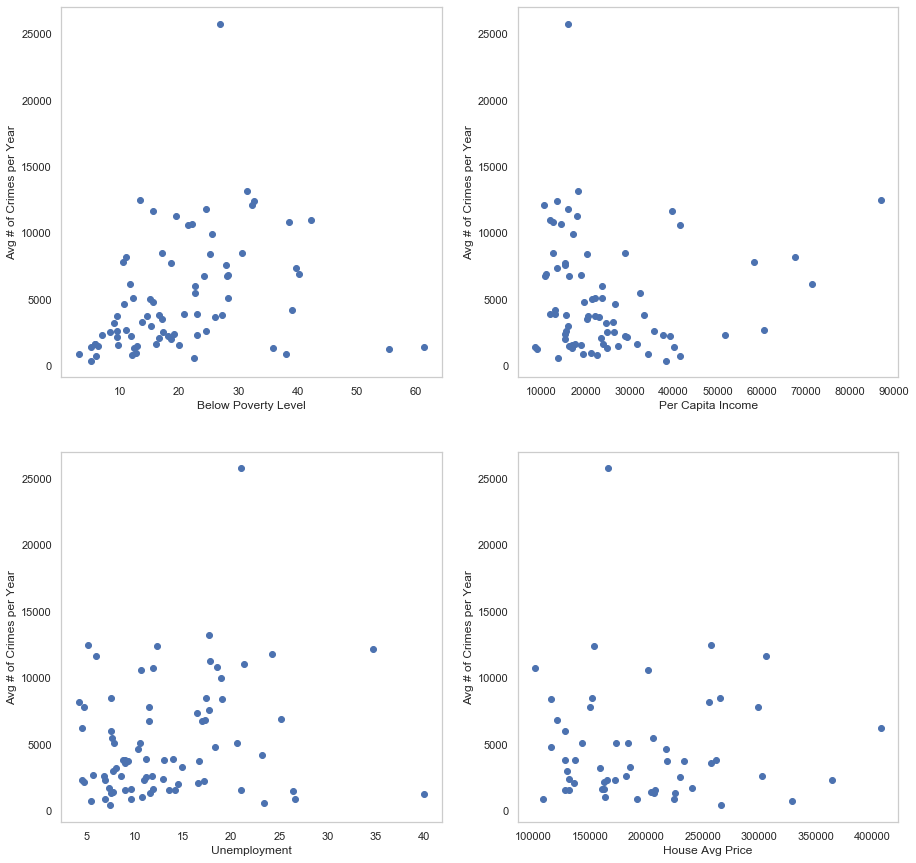

In [11]:
avg_crimes_year_2007_2011 = crimes_2007_2011.groupby('Community Area').resample('Y').size().mean(axis=1)

# number of crimes per region
fig, ax = plt.subplots(2, 2, figsize=(15,15))
for i, indicator in enumerate(eco_indicators):
    ax_ix = (i//2, i%2)
    ax[ax_ix].scatter(x=eco_2011[indicator],
                      y=avg_crimes_year_2007_2011)
    ax[ax_ix].set_xlabel(indicator)
    ax[ax_ix].set_ylabel('Avg # of Crimes per Year')

In [12]:
# average number of crimes per community in 2007-2011
crimes_df['2007':'2011'].groupby('Community Area').resample('Y').size().mean().mean()

5135.381818181819

In [13]:
avg_crimes_year_2007_2011[avg_crimes_year_2007_2011 == avg_crimes_year_2007_2011.max()]

Community Area
25.0    25762.4
dtype: float64

So, that community is Austin, the second largest community area by population, which helps explain the huge number of crimes there.

Let's compute **crimes per capita** per region.

**Note:** using most recent population estimates, from the 2010 census.

In [14]:
pop_comm = pd.read_pickle('data/external/Population_by_Community_Area.pkl')

In [15]:
eco_2011 = eco_2011.join(pop_comm)
eco_2011.rename(columns = {'2010': '2010 Population',
                           '2000': '2000 Population'},
               inplace=True)

In [16]:
eco_2011.head()

,Community Area Name,Below Poverty Level,Per Capita Income,Unemployment,House Avg Price,2010 Population,2000 Population
Community Area,,,,,,,
1,Rogers Park,22.7,23714,7.5,128225.000000,54991,63484
2,West Ridge,15.1,21375,7.9,173050.000000,71942,73199
3,Uptown,22.7,32355,7.7,206100.000000,56362,63551
4,Lincoln Square,9.5,35503,6.8,302383.333333,39493,44574
5,North Center,7.1,51615,4.5,364525.000000,31867,31895


In [17]:
crime_2007_2011_per_comm = pd.DataFrame(avg_crimes_year_2007_2011/eco_2011['2010 Population'],
                                        columns=['Crimes per Capita'])

### Crimes per Capita per Region

In [18]:
arrest_2007_2011_per_comm = crimes_2007_2011.groupby(['Community Area', 'Arrest']).resample('Y').size().mean(axis=1)
crime_2007_2011_per_comm['Proportion of Arrests'] = arrest_2007_2011_per_comm.xs(True, level='Arrest')/avg_crimes_year_2007_2011

eco_2011 = eco_2011.join(crime_2007_2011_per_comm)

In [19]:
eco_2011.head()

,Community Area Name,Below Poverty Level,Per Capita Income,Unemployment,House Avg Price,2010 Population,2000 Population,Crimes per Capita,Proportion of Arrests
Community Area,,,,,,,,,
1,Rogers Park,22.7,23714,7.5,128225.000000,54991,63484,0.108949,0.288323
2,West Ridge,15.1,21375,7.9,173050.000000,71942,73199,0.070248,0.189244
3,Uptown,22.7,32355,7.7,206100.000000,56362,63551,0.097339,0.299296
4,Lincoln Square,9.5,35503,6.8,302383.333333,39493,44574,0.066554,0.188023
5,North Center,7.1,51615,4.5,364525.000000,31867,31895,0.073223,0.166624


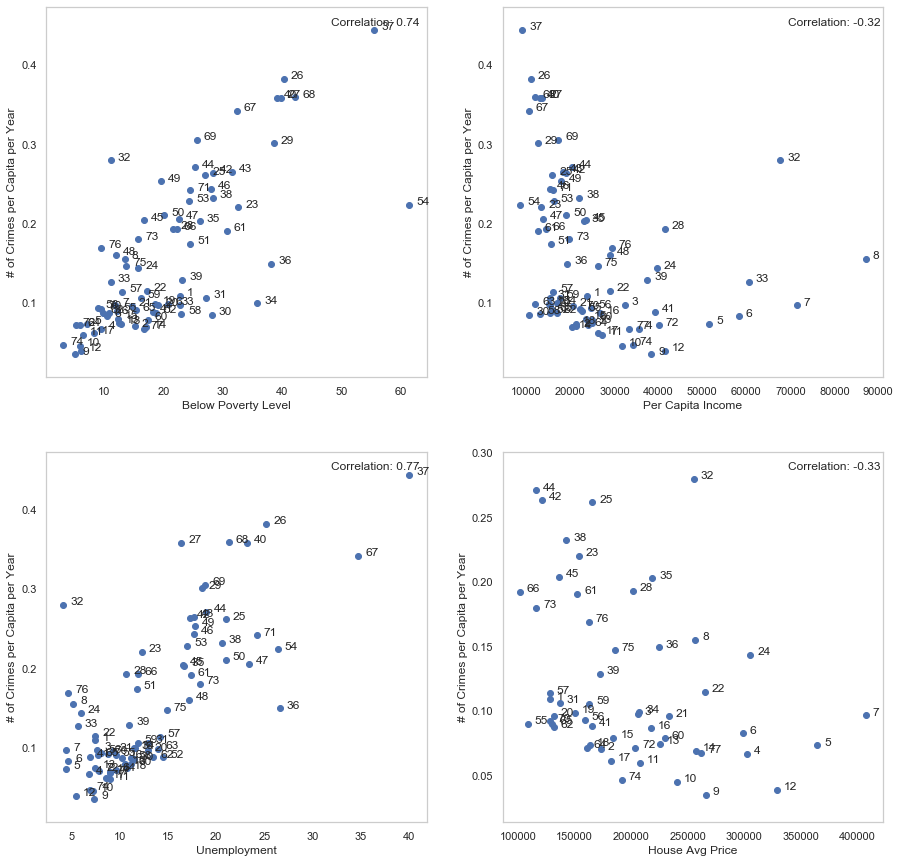

In [20]:
# crimes per capita per region
fig, ax = plt.subplots(2, 2, figsize=(15,15))

for i, indicator in enumerate(eco_indicators):    
    ax_ix = (i//2, i%2)
    x, y = eco_2011[indicator], eco_2011['Crimes per Capita']
    ax[ax_ix].scatter(x, y)
    # color by Proportion of Arrests:
#     ax[ax_ix].scatter(x, y, c=crime_2007_2011_per_comm['Proportion of Arrests'], cmap='Reds')
    ax[ax_ix].set_xlabel(indicator)
    ax[ax_ix].set_ylabel('# of Crimes per Capita per Year')

    # let's also check the numeric correlation
    ax[ax_ix].annotate('Correlation: {}'.format(eco_2011['Crimes per Capita'].corr(eco_2011[indicator]).round(decimals=2)),
                       xy=(.75, .95),
                       xycoords='axes fraction')
    
    # add annotation of Community Area ID
    for i, s in pd.concat([x,y], axis=1).iterrows():
        text = int(i)
        ax[ax_ix].annotate(text,
                           xy = (s[indicator], s['Crimes per Capita']),
                           xytext = (7, 0),
                           textcoords = 'offset points')
        # highlight specified communities
#         comm = [37,26,54]
#         if int(i) in comm:
#             ax[ax_ix].scatter(s[indicator], s['Crimes per Capita'], color='red')

### What's up with some communities?

#### Community 32

From the plots above, it looks like community 32 is a well-off community, but the number of crimes committed in it is quite large. Let's investigate it further.

In [21]:
# what community is it?
eco_2011.loc[32, 'Community Area Name']

'Loop'

From [Wikipedia](https://en.wikipedia.org/wiki/Chicago_Loop):

> The Loop, one of Chicago's 77 designated community areas, is the central business district in the downtown area of the city. It is home to Chicago's commercial core, City Hall, and the seat of Cook County. 

#### Communities 26 and 37

On the other hand, communities 26 and 37 look very poor and are plagued by a high number of crimes per capita. Let's see what they are. 

In [22]:
# what community is it?
poor_comms = [26, 37]
eco_2011.loc[poor_comms, 'Community Area Name']

Community Area
26    West Garfield Park
37           Fuller Park
Name: Community Area Name, dtype: object

Let's break down the types of crimes committed in these communities.

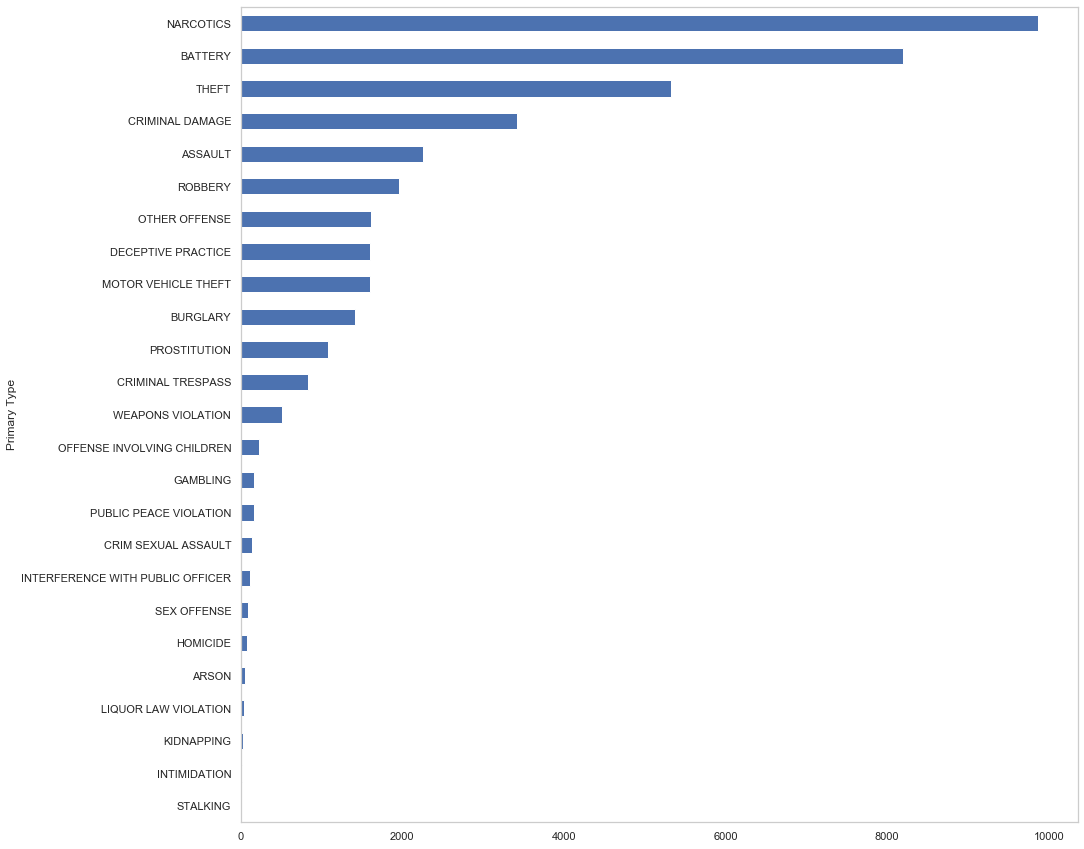

In [23]:
crimes_2007_2011[crimes_2007_2011['Community Area'].isin(poor_comms)].groupby('Primary Type').size().sort_values().plot.barh(figsize=(15,15));

### Crimes per Capita per Region with Arrests

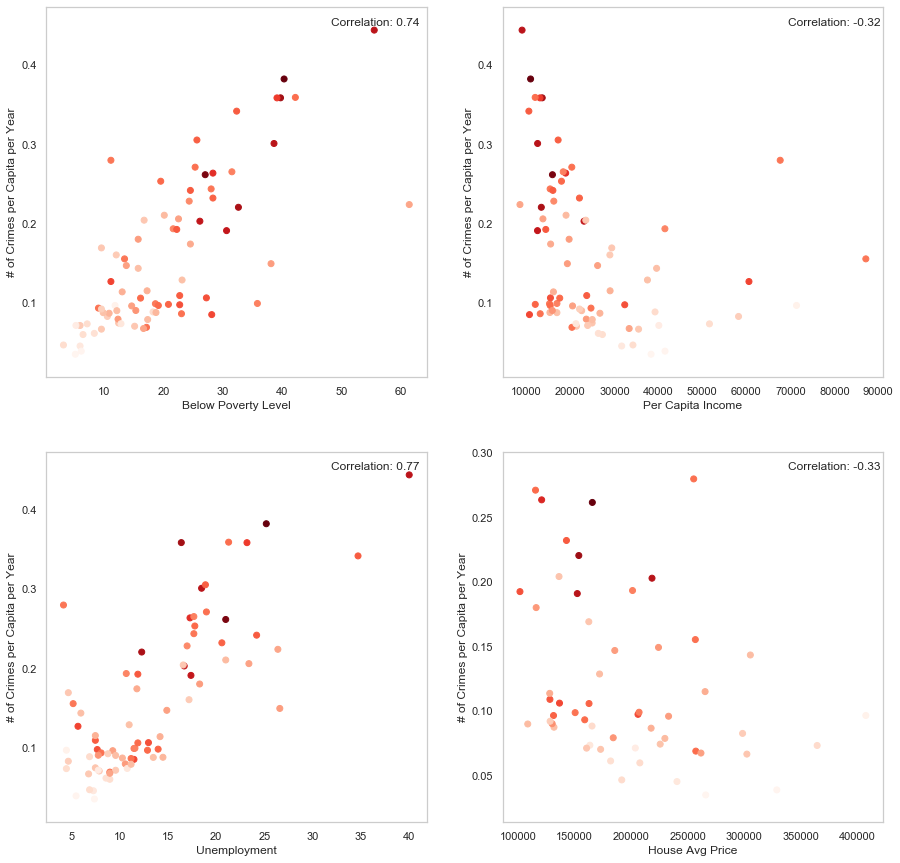

In [24]:
# crimes per capita per region
fig, ax = plt.subplots(2, 2, figsize=(15,15))

for i, indicator in enumerate(eco_indicators):    
    ax_ix = (i//2, i%2)
    x, y = eco_2011[indicator], eco_2011['Crimes per Capita']
    # color by Proportion of Arrests:
    ax[ax_ix].scatter(x, y, c=eco_2011['Proportion of Arrests'], cmap='Reds')
    ax[ax_ix].set_xlabel(indicator)
    ax[ax_ix].set_ylabel('# of Crimes per Capita per Year')

    # let's also check the numeric correlation
    ax[ax_ix].annotate('Correlation: {}'.format(eco_2011['Crimes per Capita'].corr(eco_2011[indicator]).round(decimals=2)),
                       xy=(.75, .95),
                       xycoords='axes fraction')

#### Investigate communities with many arrests

I suspect these communities have a high number of arrests because the most common crime in them is narcotics. Let's test that hypothesis.

In [16]:
top_arrest_comms = eco_2011.sort_values('Proportion of Arrests', ascending=False)['Community Area']
top_10_arrest = top_arrest_comms.values[:10]
top_10_arrest

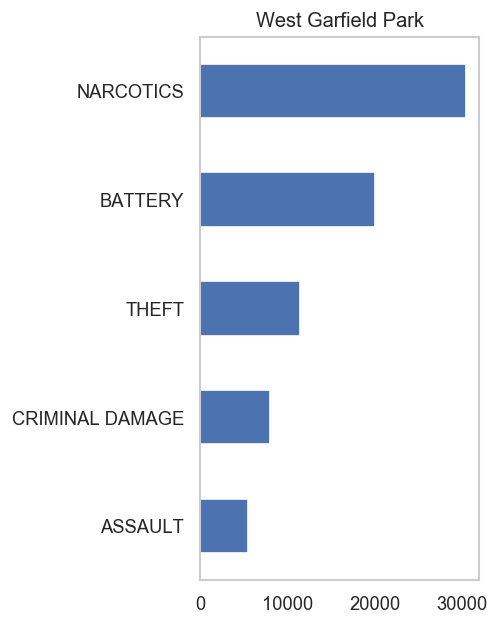

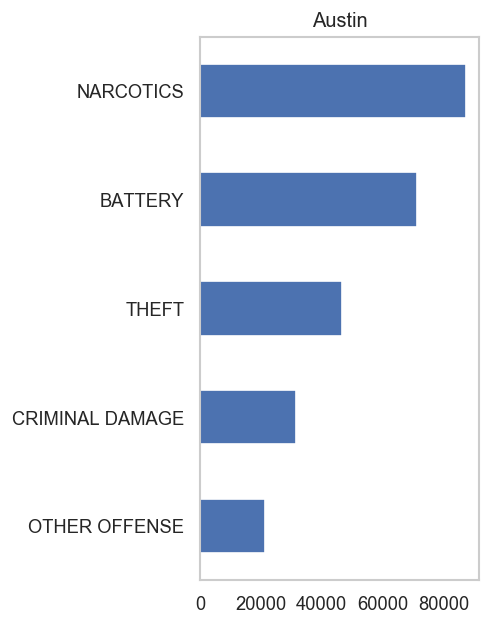

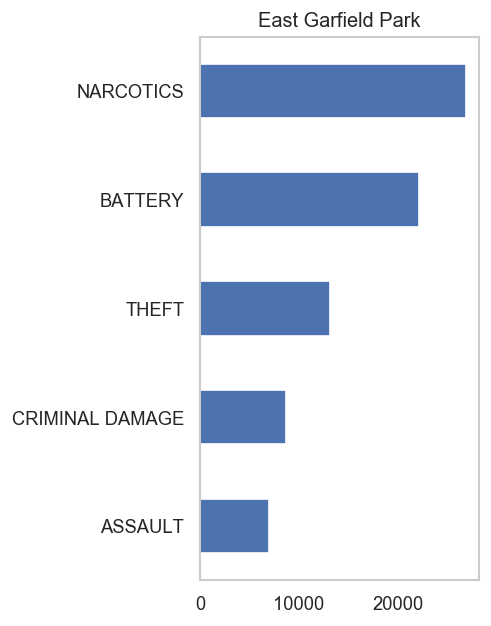

In [127]:
for comm in top_10_arrest[:3]:
    plt.figure(figsize=(3,6), dpi=120)
    crimes_df[crimes_df['Community Area'] == comm].groupby('Primary Type').size().sort_values()[-5:].plot.barh()
    plt.title(eco_2011.loc[eco_2011['Community Area'] == comm, 'Community Area Name'].values[0])
    plt.ylabel(None)
    plt.savefig(str(comm)+'_common_crimes', bbox_inches='tight')

### Crimes per Capita per Region with Violent Crimes

Now let's color the points by the **proportion of violent crimes** in each community.

In [25]:
# Violent crimes:
# Homicide 1st & 2nd Degree (01A) (Index)
# Criminal Sexual Assault (02) (Index)
# Robbery (03) (Index)
# Aggravated Assault (04A) (Index)
# Aggravated Battery (04B) (Index)

violent_crimes_IUCR = [
    '0110','0130','0261','0262','0263','0264','0265',
    '0266','0271','0272','0273','0274','0275','0281',
    '0291','1753','1754','0312','0313','031A','031B',
    '0320','0325','0326','0330','0331','0334','0337',
    '033A','033B','0340','051A','051B','0520','0530',
    '0550','0551','0552','0553','0555','0556','0557',
    '0558','041A','041B','0420','0430','0450','0451',
    '0452','0453','0461','0462','0479','0480','0481',
    '0482','0483','0485','0488','0489','0490','0491',
    '0492','0493','0495','0496','0497','0498','0510'
]

In [40]:
eco_2011['Proportion of Violent Crimes'] = crimes_2007_2011[crimes_2007_2011['IUCR'].isin(violent_crimes_IUCR)].\
                                           groupby('Community Area').resample('Y').size().mean(axis=1)/avg_crimes_year_2007_2011

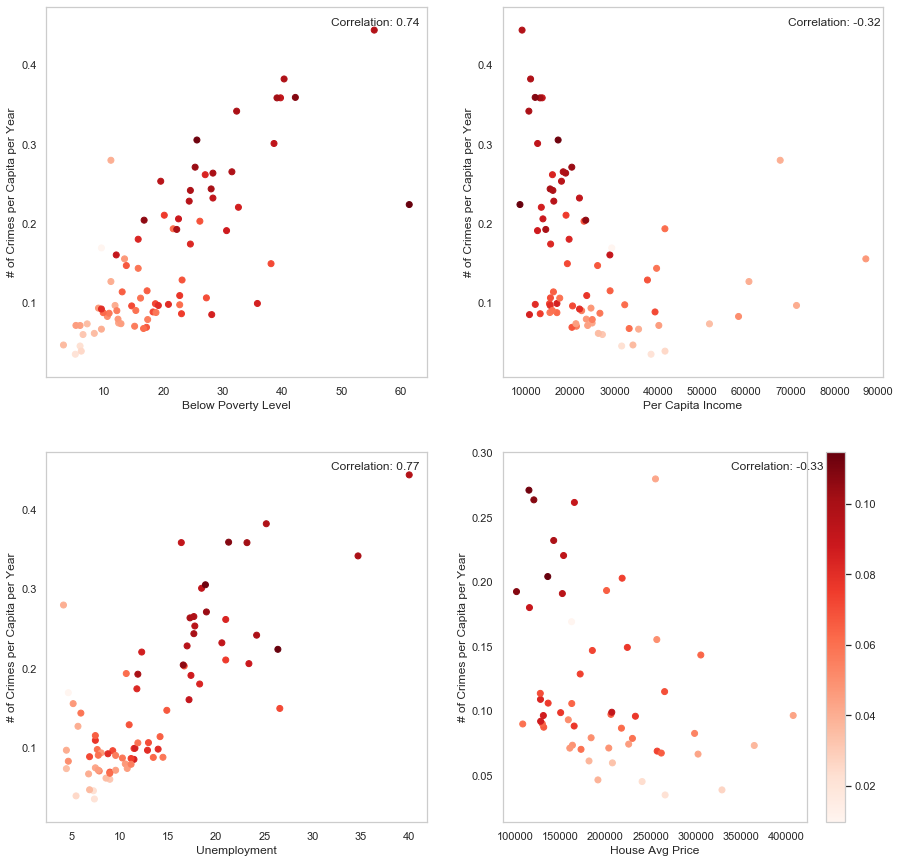

In [41]:
# crimes per capita per region
fig, ax = plt.subplots(2, 2, figsize=(15,15))

for i, indicator in enumerate(eco_indicators):    
    ax_ix = (i//2, i%2)
    x, y = eco_2011[indicator], eco_2011['Crimes per Capita']
    # color by Proportion of Arrests:
    plot = ax[ax_ix].scatter(x, y, c=eco_2011['Proportion of Violent Crimes'], cmap='Reds')
    ax[ax_ix].set_xlabel(indicator)
    ax[ax_ix].set_ylabel('# of Crimes per Capita per Year')

    # let's also check the numeric correlation
    ax[ax_ix].annotate('Correlation: {}'.format(eco_2011['Crimes per Capita'].corr(eco_2011[indicator]).round(decimals=2)),
                       xy=(.75, .95),
                       xycoords='axes fraction')
    
fig.colorbar(plot);
# fig.tight_layout();

### Crimes per Capita per Region with Economically-Motivated Crimes

Now let's color the points by the **proportion of crimes motivated by financial gain** in each community.

In [29]:
robbery_IUCR = [
    '0312','0313','031A','031B','0320','0325','0326',
    '0330','0331','0334','0337','033A','033B','0340'
]
burglary_IUCR = [
    '0610','0620','0630','0650'
]
theft_IUCR = [
    '0810','0820','0840','0841','0842','0843','0850',
    '0860','0865','0870','0880','0890','0895'
]
motor_theft_IUCR = [
    '0910','0915','0917','0918','0920','0925',
    '0927','0928','0930','0935','0937','0938'
]

crisis_IUCR = robbery_IUCR + burglary_IUCR + theft_IUCR + motor_theft_IUCR

In [43]:
eco_2011['Proportion of Financial Crimes'] = crimes_2007_2011[crimes_2007_2011['IUCR'].isin(crisis_IUCR)].\
                                             groupby('Community Area').resample('Y').size().mean(axis=1)/avg_crimes_year_2007_2011

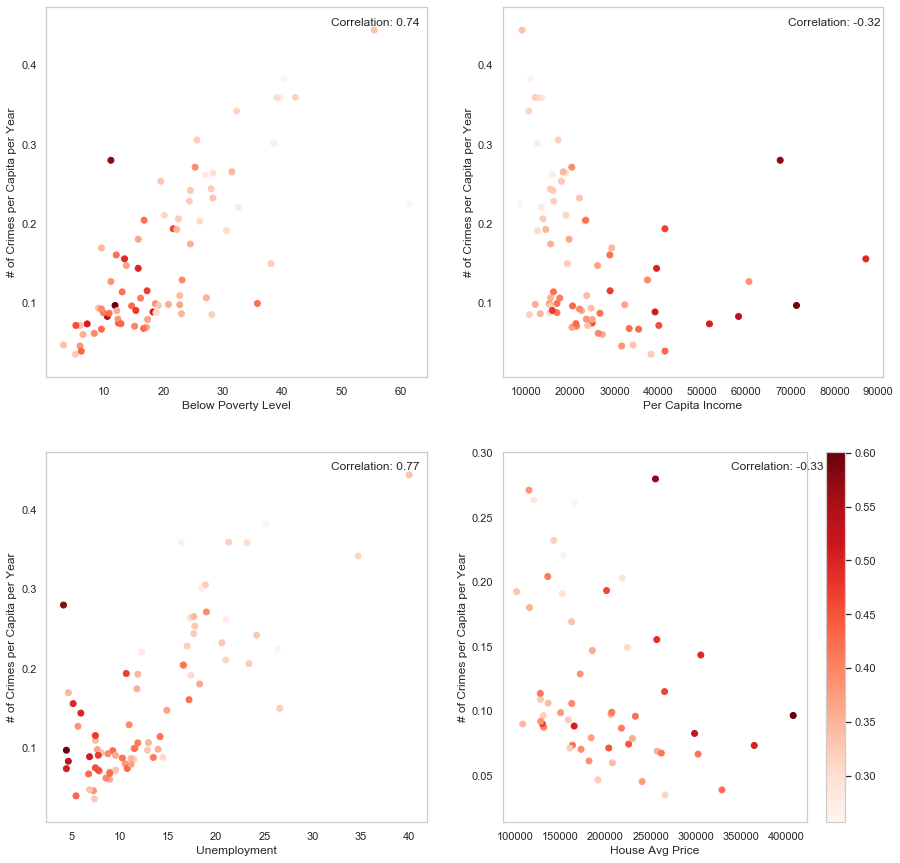

In [44]:
# crimes per capita per region
fig, ax = plt.subplots(2, 2, figsize=(15,15))

for i, indicator in enumerate(eco_indicators):    
    ax_ix = (i//2, i%2)
    x, y = eco_2011[indicator], eco_2011['Crimes per Capita']
    # color by Proportion of Arrests:
    plot = ax[ax_ix].scatter(x, y, c=eco_2011['Proportion of Financial Crimes'], cmap='Reds')
    ax[ax_ix].set_xlabel(indicator)
    ax[ax_ix].set_ylabel('# of Crimes per Capita per Year')

    # let's also check the numeric correlation
    ax[ax_ix].annotate('Correlation: {}'.format(eco_2011['Crimes per Capita'].corr(eco_2011[indicator]).round(decimals=2)),
                       xy=(.75, .95),
                       xycoords='axes fraction')
    
fig.colorbar(plot);
# fig.tight_layout();

## Export data

In [45]:
# save file with data about Economic Indicators investigation in 2007-2011
eco_2011.to_csv('data/Economic Indicators and Crime 2011.csv')

In [4]:
# load data to continue work
eco_2011 = pd.read_csv('data/Economic Indicators and Crime 2011.csv')